# 利用重新取数后的样本进行区分正负样本，重新拟合发病模型
输入正样本：该场区哺乳仔猪检出PED的前15天 （包括第15天）
输出负样本：该场区哺乳仔猪无检出PED（未检出）

# 数据库

In [22]:
import sys
import re
from pyhive import hive
import pandas as pd
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
import scipy.stats as stats
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import StandardScaler
import requests
import json
import time
from matplotlib import pyplot as plt

from matplotlib.font_manager import FontProperties
font = FontProperties('simhei', size=20) #中文字体


pd.set_option('display.max_columns', None) #显示所有列
sys.path.append('/data/datamining/Py_functions/get_data')
from get_data_func import * ##取数function  


In [23]:
hiveConn = hive.Connection(host='10.106.20.15', port=10000, username='szchenye', password='szcy230#',
                                       database='mydw', auth='CUSTOM')

# 取数样本, 预处理样本

In [24]:
# 输入
dataset = pd.read_csv('21_01m_22_01m_data.csv')
dataset = dataset.iloc[:, 1:] #去掉 unname 那一列

# 输出
new_ped_data = pd.read_csv('重新取数数据表/抗原检测重新取数成果.csv')
# 场区列表
hiveConn2 = hive.Connection(host='10.106.20.15', port=10000, username='szchenye', password='szcy230#',
                                       database='myana', auth='CUSTOM')

field_sql = '''SELECT DISTINCT ffieldid, ffield FROM  myana.datamining_DIM_AF '''
field_df = pd.read_sql(field_sql, hiveConn2)
new_ped_data = new_ped_data.merge(field_df, how = 'left', on = 'ffieldid')

In [25]:
new_ped_data

,ffieldid,sampling_time,result_determine,ffield
0,15618805,2021-01-01,无法匹配,泗县牧原3场生长场
1,15618805,2021-01-02,无法匹配,泗县牧原3场生长场
2,15618805,2021-01-03,无法匹配,泗县牧原3场生长场
3,15618805,2021-01-04,无法匹配,泗县牧原3场生长场
4,15618805,2021-01-05,无法匹配,泗县牧原3场生长场
...,...,...,...,...
682180,15382148,2021-12-27,未送检,富裕牧原试验场
682181,15382148,2021-12-28,未送检,富裕牧原试验场
682182,15382148,2021-12-29,未送检,富裕牧原试验场
682183,15382148,2021-12-30,未送检,富裕牧原试验场


In [26]:
def sickmodel_label(new_ped_data):
    '''给发病模型贴标签。正样本为该场区检出PED前15天（包括检出当天）， 负样本为其他时间
    输入：dataframe
    输出：dataframe, 所有场区2021-01-01 到2022-01-03每天的标签
    输入正样本：该场区哺乳仔猪检出PED的前15天 （包括第15天） 输出负样本：该场区哺乳仔猪无检出PED（未检出）'''
    
    new_ped_data_copy = new_ped_data.copy()
    
    #首先定义所有未送检为负样本
    new_ped_data_copy.loc[new_ped_data_copy.result_determine == '未检出', 'label'] = 0
    
    #其次定义所有检出，前15天包括第15天，为正样本 
    positive_index_list = list(new_ped_data.loc[(new_ped_data.result_determine == '检出')&(new_ped_data.sampling_time > '2021-01-15')].index) #所有检出的序列列表, 在1月15日之前检出的不考虑研究
    for i in positive_index_list:
        new_ped_data_copy.iloc[i-15:i+1, -1] = 1
        
    # 但这种做法也会导致一些’无法匹配‘的场区配到label = 1的标签
    # 所以要经过再一轮的筛选，剩下有label并且不是无法判断的场区
    output = new_ped_data_copy.loc[(new_ped_data_copy.result_determine != '无法匹配')&(new_ped_data_copy.label.notnull())]
        
    return output
        
labelled_data = sickmodel_label(new_ped_data)


(array([116513.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 132680.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

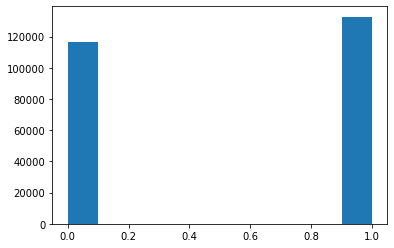

In [27]:
plt.hist(labelled_data.label)

In [18]:
# 那么训练数据就是2021-01-15后的数据
train_set = labelled_data.loc[labelled_data.sampling_time > '2021-01-15'].merge(dataset, how = 'left', left_on = ['sampling_time','ffield'], right_on = ['当前时间', '场区名']).reset_index(drop = True)

#训练集和验证集
train_xin = train_set.loc[train_set.当前时间 <= '2021-11-01']
valid_xin = train_set.loc[train_set.当前时间 > '2021-12-01']

In [20]:
train_xin.label.value_counts()

1.0    100110
0.0     89818
Name: label, dtype: int64

In [21]:
#train_set.to_csv('重新取数数据表/训练数据1.csv', index = False)

# 逻辑回归

In [9]:
def data_preprocess(train_data):
    '''离散化数据，为准备拟合模型和准备预测'''
    
    from sklearn.preprocessing import KBinsDiscretizer
    data_process = train_data.copy()
    #data_process = data_process.loc[data_process.is_ped.notnull()]
    #附加一行，为了避免离散化后的特征不一致
    addtion_row = {'场区名': '附加', '该场区哺乳猪群PED阳性单元数':'未送检','当前时间子公司内阳性场区占比':'未送检', '该场区中和抗体合格率':'未送检', 
           '本场区返饲间隔(取该场区最近一次返饲时间距当前的时间间隔，只针对繁殖场)':'无数据','在群产房批次的上游怀孕批次是否返饲(返饲比例)':'无数据', 
           '在群产房批次的上游后备批次是否返饲(返饲比例)':'无数据','是否为PED阳性场区':'未送检','上游母猪是否为阳性单元/场区':'否',
           '产房检出频数(同一天检出的归为一次)':'0.0', '该场区哺乳猪群PED阳性单元数': '0.0'}
    data_process = data_process.append(addtion_row, ignore_index = True)

    #当前时间子公司内阳性场区占比
    aa = data_process.loc[data_process.当前时间子公司内阳性场区占比 != '未送检'].当前时间子公司内阳性场区占比.str.split('%').apply(lambda x: float(x[0]))
    aa = np.array(aa).reshape(-1,1)
    est = KBinsDiscretizer(n_bins = 5, encode='ordinal', strategy='uniform')
    est.fit(aa)
    Xt = est.transform(aa)
    data_process.loc[data_process.当前时间子公司内阳性场区占比 != '未送检', '当前时间子公司内阳性场区占比'] = Xt.astype(str)

    #产房检出频数(同一天检出的归为一次)
    data_process.loc[~data_process['该场区哺乳猪群PED阳性单元数'].isin(['未送检', '0.0']), '该场区哺乳猪群PED阳性单元数'] = '>=0.0' #~表示反向函数，即提取不在这个列表的行
    data_process.loc[~data_process['产房检出频数(同一天检出的归为一次)'].isin(['未送检', '0.0']), '产房检出频数(同一天检出的归为一次)'] = '>=0.0'

    #该场区中和抗体合格率
    aa = data_process.loc[data_process['该场区中和抗体合格率'] != '未送检']['该场区中和抗体合格率'].str.split('%').apply(lambda x: float(x[0]))
    aa = np.array(aa).reshape(-1,1)
    est.fit(aa)
    Xt = est.transform(aa)
    data_process.loc[data_process['该场区中和抗体合格率'] != '未送检', '该场区中和抗体合格率'] = Xt.astype(str)

    #本场区返饲间隔(取该场区最近一次返饲时间距当前的时间间隔，只针对繁殖场)
    aa = data_process.loc[data_process['本场区返饲间隔(取该场区最近一次返饲时间距当前的时间间隔，只针对繁殖场)'] != '无数据']['本场区返饲间隔(取该场区最近一次返饲时间距当前的时间间隔，只针对繁殖场)']
    aa = np.array(aa).reshape(-1,1)
    est.fit(aa)
    Xt = est.transform(aa)
    data_process.loc[data_process['本场区返饲间隔(取该场区最近一次返饲时间距当前的时间间隔，只针对繁殖场)'] != '无数据', '本场区返饲间隔(取该场区最近一次返饲时间距当前的时间间隔，只针对繁殖场)'] = Xt.astype(str)

    #在群产房批次的上游怀孕批次是否返饲(返饲比例)
    aa = data_process.loc[data_process['在群产房批次的上游怀孕批次是否返饲(返饲比例)'] != '无数据']['在群产房批次的上游怀孕批次是否返饲(返饲比例)'].str.split('%').apply(lambda x: float(x[0]))
    aa = np.array(aa).reshape(-1,1)
    est.fit(aa)
    Xt = est.transform(aa)
    data_process.loc[data_process['在群产房批次的上游怀孕批次是否返饲(返饲比例)'] != '无数据','在群产房批次的上游怀孕批次是否返饲(返饲比例)'] = Xt.astype(str)

    #在群产房批次的上游后备批次是否返饲(返饲比例)
    aa = data_process.loc[data_process['在群产房批次的上游后备批次是否返饲(返饲比例)'] != '无数据']['在群产房批次的上游后备批次是否返饲(返饲比例)'].str.split('%').apply(lambda x: float(x[0]))
    aa = np.array(aa).reshape(-1,1)
    est.fit(aa)
    Xt = est.transform(aa)
    data_process.loc[data_process['在群产房批次的上游后备批次是否返饲(返饲比例)'] != '无数据','在群产房批次的上游后备批次是否返饲(返饲比例)'] = Xt.astype(str)


    X_data = data_process.loc[:, ['该场区哺乳猪群PED阳性单元数', '是否为PED阳性场区', '产房检出频数(同一天检出的归为一次)',
                                '上游母猪是否为阳性单元/场区', '当前时间子公司内阳性场区占比', '本场区返饲间隔(取该场区最近一次返饲时间距当前的时间间隔，只针对繁殖场)', 
                               '在群产房批次的上游怀孕批次是否返饲(返饲比例)', '在群产房批次的上游后备批次是否返饲(返饲比例)']]

    #独热编码
    from sklearn.feature_extraction import DictVectorizer
    vect = DictVectorizer()
    X_data = vect.fit_transform(X_data.to_dict(orient="records"))
    
    return X_data

X_train_data = data_preprocess(train_xin)
y_train_data = list(train_xin.label) + [0] #增加了一行，所以要增加一个标签y

#拟合模型
from sklearn.linear_model import LogisticRegression
lr_l1 = LogisticRegression()
lr_l1.fit(X_train_data, y_train_data)

# 输出预测结果
def model2_0(test_data):
    '''模型2.0预测结果'''
    test_data_copy  = test_data.copy()
    test_data_copy = test_data_copy.loc[test_data_copy.是否为PED阳性场区 != '未送检']

    X_test = data_preprocess(test_data_copy)
    #预测结果
    y_test_prob = lr_l1.predict_proba(X_test)
    
    #添加字段 PED预测概率
    test_data_copy.loc[test_data_copy.是否为PED阳性场区 != '未送检', '预测PED概率'] = y_test_prob[:-1, 1] #去除最后一行附加场区的输出， 保持格式一致
    test_data_copy =  test_data_copy.sort_values(by = ['预测PED概率'],ascending= False )
    
    # 0.76以上为高风险
    test_data_copy.loc[test_data_copy.预测PED概率 > 0.7, '预测风险'] = '有风险'
    test_data_copy.预测风险 = test_data_copy.预测风险.fillna('无风险')
    
    return test_data_copy

In [127]:
model2_0(valid_xin)

,ffieldid,sampling_time,result_determine,ffield,label,区域名,子公司名,场区名,场区类型,当前时间,风险等级,原因,该场区哺乳猪群PED阳性单元数,是否为PED阳性场区,产房检出频数(同一天检出的归为一次),上游母猪是否为阳性单元/场区,当前时间子公司内阳性场区占比,该场区中和抗体合格率,本场区返饲间隔(取该场区最近一次返饲时间距当前的时间间隔，只针对繁殖场),在群产房批次的上游怀孕批次是否返饲(返饲比例),在群产房批次的上游后备批次是否返饲(返饲比例),时间维度,预测PED概率,预测风险
176093,15519704,2021-12-13,未送检,新建牧原1场综合场,1.0,江西,新建县,新建牧原1场综合场,综合场,2021-12-13,中高风险,本场区为阳性场区,未送检,是,未送检,未送检,60.0%,未送检,74.0,无数据,25.0%,30.0,0.897489,有风险
176101,15519704,2021-12-21,未送检,新建牧原1场综合场,1.0,江西,新建县,新建牧原1场综合场,综合场,2021-12-21,中高风险,本场区为阳性场区,未送检,是,未送检,未送检,64.29%,未送检,74.0,无数据,33.33%,30.0,0.897489,有风险
176089,15519704,2021-12-08,未检出,新建牧原1场综合场,0.0,江西,新建县,新建牧原1场综合场,综合场,2021-12-08,中高风险,本场区为阳性场区,未送检,是,未送检,未送检,60.0%,未送检,74.0,无数据,20.0%,30.0,0.897489,有风险
176090,15519704,2021-12-10,未送检,新建牧原1场综合场,1.0,江西,新建县,新建牧原1场综合场,综合场,2021-12-10,中高风险,本场区为阳性场区,未送检,是,未送检,未送检,60.0%,未送检,74.0,无数据,27.27%,30.0,0.897489,有风险
176091,15519704,2021-12-11,未送检,新建牧原1场综合场,1.0,江西,新建县,新建牧原1场综合场,综合场,2021-12-11,中高风险,本场区为阳性场区,未送检,是,未送检,未送检,60.0%,未送检,74.0,无数据,27.27%,30.0,0.897489,有风险
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67332,15468159,2021-12-30,未检出,永济牧原10场1区繁殖场,0.0,山西省,永济,永济牧原10场1区繁殖场,繁殖场,2021-12-30,中高风险,场区怀孕及后备批次返饲比例<50%,0.0,否,0.0,否,17.71%,6.25%,无数据,0.0%,0.0%,30.0,0.191969,无风险
67864,15325650,2021-12-15,未检出,海兴牧原2场繁殖场,0.0,河北省,海兴,海兴牧原2场繁殖场,繁殖场,2021-12-15,中高风险,场区怀孕及后备批次返饲比例<50%,0.0,否,0.0,否,0.0%,10.0%,无数据,0.0%,13.33%,30.0,0.191969,无风险
67865,15325650,2021-12-17,未检出,海兴牧原2场繁殖场,0.0,河北省,海兴,海兴牧原2场繁殖场,繁殖场,2021-12-17,中高风险,场区怀孕及后备批次返饲比例<50%,0.0,否,0.0,否,0.0%,33.33%,无数据,0.0%,7.14%,30.0,0.191969,无风险
67866,15325650,2021-12-20,未检出,海兴牧原2场繁殖场,0.0,河北省,海兴,海兴牧原2场繁殖场,繁殖场,2021-12-20,中高风险,场区怀孕及后备批次返饲比例<50%,0.0,否,0.0,否,0.0%,33.33%,无数据,0.0%,7.14%,30.0,0.191969,无风险


In [10]:
X_valid = data_preprocess(train_xin)
y_valid = list(train_xin.label) + [0] 
y_pred_valid = lr_l1.predict(X_valid)
y_valid_prob = lr_l1.predict_proba(X_valid)[:,1]

from sklearn.metrics import accuracy_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss

print('正确率',accuracy_score(y_valid,y_pred_valid))
print('精准率',precision_score(y_valid,y_pred_valid))
print('召回率',recall_score(y_valid,y_pred_valid))
print('调和平均值F1',f1_score(y_valid,y_pred_valid))
[fpr, tpr, thr] = roc_curve(y_valid, y_valid_prob)
print('AUC', auc(fpr, tpr))
print('对数损失', log_loss(y_valid, y_valid_prob))

正确率 0.6765949381084511
精准率 0.6950567734909142
召回率 0.688502647088203
调和平均值F1 0.6917641863546036
AUC 0.7288298145534385
对数损失 0.6086370197858205
